# Queries on the sample Redshift dataset 

### Setup the notebook

In [2]:
from pyhive import hive
from pprint import pprint
import pandas as pd
import os
from altair import *

import IPython.display
def draw(spec):
    IPython.display.display({
        'application/vnd.vegalite.v1+json': spec.to_dict()
    }, raw=True)

pd.set_option('display.max_colwidth', -1) # dont truncate table columns
cwd = os.getcwd()
cwd="/data/shared/snap-samples/Redshift"

c = hive.Connection(host="0.0.0.0",port=10000,auth='NOSASL')
pd.read_sql('show tables',c)

def sql(q, explain=False) :
    # silly hack to handle filesystem prefix for us when creating local tables
    if "{prefix}" in q:
        q = q.replace('{prefix}',cwd)
    df=pd.read_sql(q,c)
    return df

def explain(q):
    df = sql("explain " + q)
    plan = df['plan'][0]
    pprint(plan)
    

sql('show tables')

## Query on quantity of tickets sold and price paid by date : 
Compare sales of all users to users who liked Jazz and Concerts

In [3]:
q="""
with allusers AS ( 
select caldate adate, city,sum(qtysold) q, sum(pricepaid) p 
from salessnap group by caldate,city)
,
someusers AS (
select caldate sdate,city, sum(qtysold) a, sum(pricepaid) b 
from salessnap where likeconcerts='TRUE' AND likejazz='TRUE' group by caldate,city)

select adate,allusers.city, a, b, round(a/q,2)*100 qratio , round(b/p,2)*100 pratio
from allusers, someusers where adate=sdate order by pratio desc limit 5000
"""

### Run the query

In [4]:
df=sql(q)

In [5]:
df.columns

Index([u'adate', u'city', u'a', u'b', u'qratio', u'pratio'], dtype='object')

### Charting the result

Histogram of number of tickets sold

In [6]:
a=Chart(df).mark_bar().encode(x=X('a',
  bin=Bin(maxbins=10)),y='count(*)')
draw(a)

### Timeseries of number of tickets sold

In [7]:
a=Chart(df).mark_line().encode( x=X('adate'), y='sum(a)')
draw(a)

In [8]:
from datetime import datetime, timedelta, date


In [9]:
df['yearmon']=pd.to_datetime(df['adate'],format="%Y-%m-%d" ).dt.strftime("%Y%m")

### Plot of Qty sold by month 

In [10]:
a=Chart(df).mark_line().encode( x=X('yearmon'), y='sum(a)')
draw(a)

In [11]:
df['a'].autocorr(lag=30)

0.0073864466923390382

## Query 2 : 

Use of windowing to find quantity sold compared to quantity sold 
over a 40 day window

In [15]:
s1="""
with firstseries AS
(
select caldate adate, sum(qtysold) q
from salessnap group by caldate
)

select * from 
( select adate , q, lead(q, 40)
     
   over ( order by adate desc) as qlag
   from firstseries  ) a
"""

In [16]:
df=sql(s1)

## Scatter plot of

 quantity sold (q)  quantity sold 40 days back( qlag) : Autocorrelation

In [17]:
a=Chart(df).mark_circle().encode( x='q', y='qlag')
draw(a)

As expected autocorrelation plot of q vs q

In [18]:
a=Chart(df).mark_circle().encode( x='q', y='q')
draw(a)

In [19]:
df['q'].corr(df['qlag'])

-0.044980892625506926

In [20]:
df

#### 5 day Lag of quantity sold

In [21]:
s3=""" with firstseries AS 
( select caldate adate, sum(qtysold) q 
from salessnap group by caldate ) 
select adate, q, qlag,( (q-qlag)/(case when qlag=0 then 1 else qlag end) ) as change
from ( select adate , q, lead(q, 5) over ( order by adate desc) as qlag
from firstseries  ) a order by adate desc
"""

In [22]:
sql(s3)

## We will use FBPROPHET to demo a simple forecase

https://facebook.github.io/prophet/docs/quick_start.html#python-api

In [23]:
## Forecasting using fbprophet

%matplotlib inline
import pandas as pd
from fbprophet import Prophet

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Change adate to datetime data type

The data for forecasting is based on the query 2 run on SNAP earlier

In [27]:
df['adate']=pd.DatetimeIndex(df['adate'])


In [38]:
df1=df[['adate','q']]

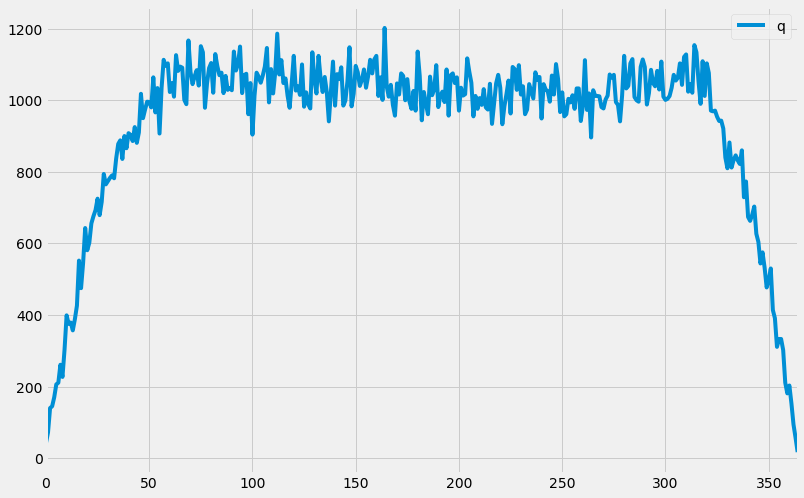

In [40]:
df1.plot(figsize=(12, 8))

In [41]:
df1.head()

adate    q
0 2008-12-31  42 
1 2008-12-30  72 
2 2008-12-29  140
3 2008-12-28  145
4 2008-12-27  170

Prophet requires this rename 

In [44]:
df1 = df1.rename(columns={'adate': 'ds',
                        'q': 'y'})
my_model = Prophet(interval_width=0.80)


In [45]:
my_model.fit(df1)


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [49]:
future_dates = my_model.make_future_dataframe(periods=6)
future_dates.tail()

ds
366 2009-01-02
367 2009-01-03
368 2009-01-04
369 2009-01-05
370 2009-01-06

In [50]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


ds        yhat  yhat_lower  yhat_upper
366 2009-01-02  331.547324  228.129212  435.920553
367 2009-01-03  313.443619  207.436086  422.974817
368 2009-01-04  326.697198  226.746902  434.132720
369 2009-01-05  311.000159  205.441532  419.899672
370 2009-01-06  288.891468  180.170917  388.772514

In [51]:
my_model.plot(forecast)

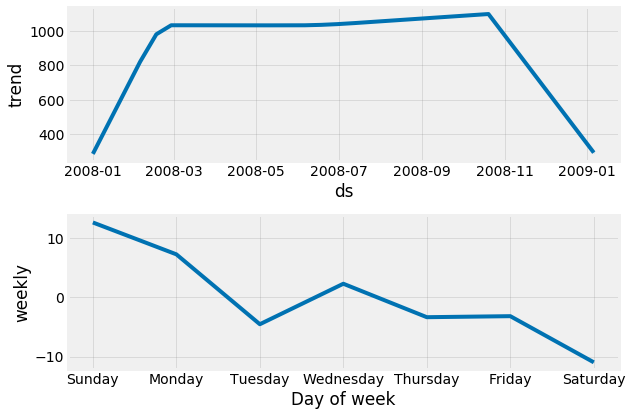

In [52]:
my_model.plot_components(forecast)